In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif 
from sklearn.feature_selection import SelectKBest
import math

In [2]:
# import dataset
df = pd.read_csv('trainDataset.csv', index_col=False)

#drop ID column from dataset
df = df.iloc[:, 1:]

In [3]:
# DELETE MISSING VALUES

#delete missing values (999) of each column
for column in df:
    df[column]=df[column].replace(999, None)

df = df.dropna()

final_df_classif = df
final_df_reg = df

#namelist of columns that has categorical data or do not need normalisation for classification
drop_classif = ['pCR (outcome)', 'ER', 'PgR', 'HER2', 'TrippleNegative', 'ChemoGrade', 'Proliferation', 'HistologyType', 'LNStatus', 'TumourStage']

#drop the columns with booleans/specific grades as they wont have outliers
df_classif = df.drop(drop_classif, axis=1)

In [4]:
# REPLACING OUTLIERS

#use IQR method to find outliers
def IQR_outliers(column):
    Q1=df[column].quantile(0.25)
    Q3=df[column].quantile(0.75)
    IQR = Q3-Q1
    df_outliers=df[((df[column]<(Q1-1.5*IQR)) | (df[column]>(Q3+1.5*IQR)))]
    return df_outliers

#delete outliers
def replace_outliers(df1, df2, drop_list):
    for column in df1:
        if column not in drop_list:
            df_outliers = IQR_outliers(column)
            for i in range((df_outliers.shape[0])):
                label_index = df_outliers.index[i]
                df2.loc[label_index, column] = df2[column].median()
    return df2

final_df_classif = replace_outliers(df_classif, final_df_classif, drop_classif)

In [5]:
# NORMALISATION

def normalize(df, x):
    result = df.copy()
    for feature_name in df.columns:
        if (x == 'classification' and feature_name not in drop_classif) or (x == 'regression' and feature_name not in drop_reg):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

normalised_df_classif = normalize(final_df_classif,'classification')

In [6]:
# FEATURE SELECTION
# Classification

#separate target variable for classification (PCR)
x_classif = normalised_df_classif.drop(labels=['pCR (outcome)'], axis=1)
y_classif = normalised_df_classif['pCR (outcome)']

#apply ANOVA for classification

fs = SelectKBest(score_func = f_classif, k= 53)  #k value for when P_value < 0.05

# Apply feature selection
fs.fit(x_classif,y_classif)

#declare variable to put selected features for classification
df_classif_final = pd.DataFrame()

def list_ceil(x):
    return[math.ceil(i) in x]

features_score = pd.DataFrame(fs.scores_)
features_pvalue = pd.DataFrame(np.round(fs.pvalues_,4))
features = pd.DataFrame(x_classif.columns)
feature_score = pd.concat([features,features_score,features_pvalue],axis=1)

# Assign column names
feature_score.columns = ['Input_Features','Score','P_Value']
chosen_features = feature_score.nlargest(53,columns='Score')

# Add selected features into a new dataframe
for feature in chosen_features['Input_Features']:
    df_classif_final = pd.concat([df_classif_final, normalised_df_classif[feature]], axis=1)

In [7]:
df = df_classif_final
X = x_classif
y = y_classif.astype(int)

# Split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [8]:
# K-fold cross validation

def Classkf(ag, X, y, name):
    n_folds = 5
    cv_error = np.average(cross_val_score(ag, X, y, cv=n_folds))
    print('The {}-fold cross-validation accuracy score for {} is {:.2f} '.format(n_folds, name, cv_error))

# plot

def Classplot(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(cm, cmap=plt.cm.Reds, alpha=0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')
    plt.xlabel('Predicted Values', )
    plt.ylabel('Actual Values')

In [9]:
# SVM

from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(svm.SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

print(grid.best_estimator_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, k

[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=   0.0s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=   0.0s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=   0.0s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=   0.0s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=   0.0s
[CV] END ......................C=10, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ......................C=10, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ...................

The 5-fold cross-validation accuracy score for SVM is 0.77 


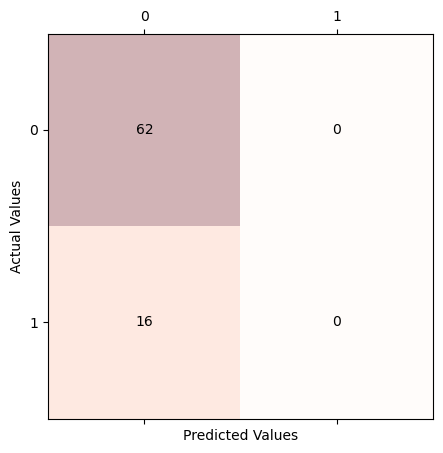

In [10]:
clf = svm.SVC(C=10, kernel='sigmoid', gamma=0.1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
name = 'SVM'
Classkf(clf, X, y, name)
Classplot(y_test, y_pred, name)

The 5-fold cross-validation accuracy score for Decision Tree is 0.74 


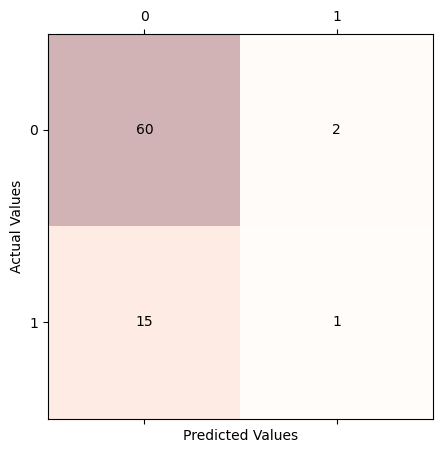

In [11]:
# Decision tree
dt = DecisionTreeClassifier(max_features= 10,
                           max_leaf_nodes= 5,
                           random_state = 42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
name = 'Decision Tree'
Classkf(dt, X, y, name)
Classplot(y_test, y_pred, name)

The 5-fold cross-validation accuracy score for MLP is 0.68 


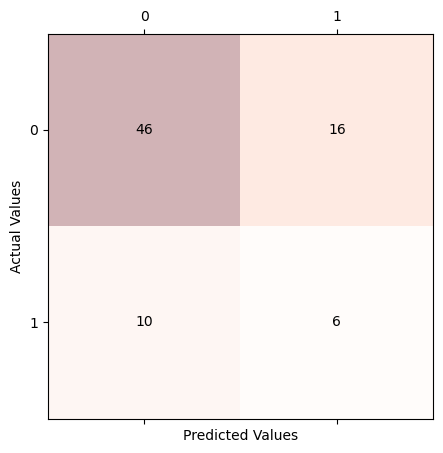

In [12]:
#MLP

mlp = MLPClassifier(hidden_layer_sizes=(6, 4), random_state=42, max_iter=50000)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
name = 'MLP'
Classkf(mlp, X, y, name)
Classplot(y_test, y_pred, name)

In [13]:
import csv

f = open('PCR.csv', 'w')

writer = csv.writer(f)

output = np.arange(len(y_pred)*2).reshape(len(y_pred),2)
i = 0
while i < len(y_pred):
    output[i][0] = i
    output[i][1] = y_pred[i]
    i = i+1

writer.writerows(output)
# close the file
f.close()